### KNUE R 기반 텍스트 분석 워크숍 Part 02 - data read & token analysis

* 예제 텍스트 데이터를 이용하여 'word' 단위로 tokenize 하여 분석 및 시각화를 하겠습니다.

## library load

In [806]:
# dplyr grammar
library(tidyverse)
library(reshape2)
library(readtext)

# text analysis
library(stringr)
library(tidytext)
library(sentimentr)

# visualization
library(ggplot2)
library(wordcloud)
library(gridExtra)
library(ggthemes)

# network analysis
library(tidygraph)
library(ggraph)


## data read

* 준비된 데이터는 tab 으로 분리되어 있는 tab separated data 입니다.
* 구분자("\t")를 지정하여 데이터를 가져올 수 있는 read_delim() 함수를 사용하여 파일을 import 합니다.
* marvel studio의 avengers 시리즈의 2편과 3편 시나리오 영문 텍스트 데이터입니다.

* 2편:age_of_ultron_script_tab_sep.txt
* 3편:infinity_war_script_tab_sep.txt 

In [767]:
a3 <- read_delim("infinity_war_script_tab_sep.txt", delim='\t')
a2 <- read_delim("age_of_ultron_script_tab_sep.txt", delim = '\t')


Parsed with column specification:
cols(
  hero = col_character(),
  script = col_character()
)
Parsed with column specification:
cols(
  hero = col_character(),
  script = col_character()
)


* avengers3 와 avengers2를 합치려고 합니다.
* 각 데이터에 구분자를 표시하고 하나로 합치겠습니다.

### 데이터가 정상적으로 read 되었는지 살펴보겠습니다.

In [768]:
head(a2,10)

hero,script
Announcer,[first lines; announcement over speaker] Report to your stations immediately. This is not a drill. We are under attack. We are under attack.
**,"[the Avengers are in the process of infiltrating a HYDRA base in Sokovia, and Iron Man bounces off of the base's force field]"
Tony Stark,Shit!
Steve Rogers,"Language! JARVIS, what's the view from upstairs?"
JARVIS,The central building is protected by some kind of energy shield. Strucker's technology is well beyond any other Hydra base we've taken.
Thor,Loki's scepter must be here. Strucker couldn't mount this defense without it. At long last.
**,[Natasha knocks out some soldiers]
Natasha Romanoff,"At long last is lasting a little long, boys."
**,[As some soldiers shoot at him]
Clint Barton,Yeah. I think we lost the element of surprise.


* 'movie' 컬럼을 추가하여 a2와 a3를 구분합니다.

In [769]:
# 구분자 넣기
a2 %>% mutate(movie = 2) -> a2
a3 %>% mutate(movie = 3) -> a3


* bind_rows() 로 합치기

In [770]:
a2 %>% bind_rows(a3) -> a

* 제대로 합쳐졌는지 확인해보겠습니다.

In [772]:
# a %>% head(10)

## data wrangling

* 데이터를 전처리해서 분석하기에 적당하도록 조작해야 합니다.
* script 컬럼에 dialogue와 action이 섞여 있습니다. dialogue만 추출하여 분석하려고 합니다.
* regular expression (정규식)을 사용하여 문자 처리를 하려고 합니다.
* 원래 텍스트에 포함되어 있던 "*" 표시를 제외하려고 합니다.
* 또한 script 중간에 [  ] 표시로 적혀 있는 action script도 제외하려고 합니다.
* 각각의 script에 일련번호를 부여하려고 합니다. 

In [773]:
# without *
(
    a
    # hero preprocess
    %>% mutate(hero2 = str_replace_all(hero,"\\**", ""))
    %>% mutate(hero3 = str_replace_all(hero2, "F.R.I.D.A.Y.", "F.R.I.D.A.Y"))
    %>% mutate(hero4 = str_replace_all(hero3, "F.R.I.D.A.Y", "FRIDAY"))
    %>% mutate(hero5 = str_replace_all(hero4, "Thor'", "Thor"))
    %>% mutate(hero6 = str_trim(hero5))
    
    # script preprocess
    %>% mutate(script2 = str_replace_all(script,"\\*\\*\\*", ""))
    %>% mutate(script3 = str_replace_all(script2,"\\*\\*", ""))
    %>% mutate(script4 = str_replace_all(script3,"\\*", ""))
    
    # dialouge extract
    %>% mutate(script_wop = str_replace_all(script4,"\\[[a-zA-Z0-9 . , : ; ' - é ? � ( ) / ! % -]+\\]",""))
    
    # add index
    %>% mutate(id = row_number())
    
    # select columns
    %>% select(id, movie, hero = hero6, script = script4, dlg = script_wop)
#     %>% head(10)
) -> a

* 제대로 전처리가 되었는지 살펴보겠습니다. dlg에 action script 를 나타내는 [ ] 표시가 있는지 살펴보았습니다. 

In [774]:
(
    a
    %>% filter(str_detect(dlg, "\\["))
    %>% summarise(n())
)

n()
0


* 분석을 위해 준비된 데이터를 살펴보겠습니다.

In [775]:
head(a, 3)

id,movie,hero,script,dlg
1,2,Announcer,[first lines; announcement over speaker] Report to your stations immediately. This is not a drill. We are under attack. We are under attack.,Report to your stations immediately. This is not a drill. We are under attack. We are under attack.
2,2,,"[the Avengers are in the process of infiltrating a HYDRA base in Sokovia, and Iron Man bounces off of the base's force field]",
3,2,Tony Stark,Shit!,Shit!


## Tokenize

* 추출된 dialogue text를 word 단위로 나누려고 합니다.

In [776]:
(
    a
    %>% select(id, movie, hero, dlg)
    %>% unnest_tokens(word, dlg)
    
) -> a_dlg_word

In [778]:
a_dlg_word %>% head(3)

id,movie,hero,word
1,2,Announcer,report
1,2,Announcer,to
1,2,Announcer,your


## Stop Words 

* 가장 많이 등장하는 단어는 무엇일까? 

In [779]:
(
    a_dlg_word
    %>% anti_join(stop_words)
    %>% filter(movie == 3)
    %>% count(word, sort=TRUE)
    %>% filter(n >= 10)
#     %>% summarise(n = count(word))
#     %>% arrange(desc(n))
) 

Joining, by = "word"


word,n
stone,48
thanos,44
time,31
stop,19
life,18
universe,16
vision,16
kill,15
gamora,14
stones,14


* 의미없는 단어를 제외하고 의미 있는 단어로 분석을 하고자 합니다.
* R의 tidytext에는 무의미한 단어를 제외하기 위한 stop words 사전을 제공하고 있습니다.

In [424]:
(
    stop_words 
    %>% filter(word == "yeah")
    #     %>% summarise(n_distinct(lexicon))
)

word,lexicon


* stop_words 사전에 있는 단어를 count에서 제외하겠습니다.
* 의미있는 단어가 아니라고 판단하여 분석에서 제외하는 것입니다.

In [359]:
(
    a_dlg_word
#     %>% filter(movie ==3)
    %>% anti_join(stop_words)
    %>% count(word, sort=TRUE)
    %>% filter(n >= 10)
    %>% head(20)
#     %>% summarise(n = count(word))
#     %>% arrange(desc(n))
) 

Joining, by = "word"


word,n
time,63
stone,53
stark,45
thanos,44
ultron,37
life,29
uh,28
world,27
alright,26
guys,26


* 그런데, stop_words 사전에 없기 때문에 포함되어 있는 단어들이 있습니다.
* 'yeah', 'gonna', 'wanna', 'hey' 같은 단어입니다.
* my_stop_words 사전을 만들어, 원래의 stop_words에 포함하면 좋을 것입니다.

In [426]:
my_stop_words <- tibble(word = c('yeah', 'gonna', 'wanna', 'hey', 'gotta'), lexicon="custom")

* 이제 원래의 stop_words에 내가 단어를 추가한 my_stop_words를 row bind 합니다.

In [427]:
stop_words %>% bind_rows(my_stop_words) -> stop_words

* 만약 분석의 맥락에서 stop_words에서 특정 단어를 제외하고 싶을 경우에는 어떻게 하면 될까요? 
* 특정 단어를 filter로 제외하고 새로운 data frame을 생성하여 그것을 기준으로 anti_join 하면 될 것입니다.

In [77]:
(
    stop_words
    %>% filter(word != "yeah")
) -> stop_words_wo_yeah

## token analysis

* token 분석을 위한 데이터가 준비되었습니다.
* 분석은 hero별로 어떤 차이가 나는지를 분석하는 것이 의미있을 것입니다. 
* 이를 위해 hero list가 있어야 정확하게 분석할 수 있습니다.
* infinity war 의 경우에는 6개의 stone을 중심으로 이야기가 전개됩니다.
* 6개 stone list가 있어야 정확하게 분석할 수 있습니다.
* hero list와 stone list를 만들려고 합니다.
* hero와 stone의 경우, 유사한 이름이 다르게 기록되어 있을 수 있기 때문에 uniqueness를 확인해야 합니다.

### hero list

In [780]:
(
    a
    %>% filter(str_length(hero) != 0)
#     %>% filter(id == 1)
)

id,movie,hero,script,dlg
1,2,Announcer,[first lines; announcement over speaker] Report to your stations immediately. This is not a drill. We are under attack. We are under attack.,Report to your stations immediately. This is not a drill. We are under attack. We are under attack.
3,2,Tony Stark,Shit!,Shit!
4,2,Steve Rogers,"Language! JARVIS, what's the view from upstairs?","Language! JARVIS, what's the view from upstairs?"
5,2,JARVIS,The central building is protected by some kind of energy shield. Strucker's technology is well beyond any other Hydra base we've taken.,The central building is protected by some kind of energy shield. Strucker's technology is well beyond any other Hydra base we've taken.
6,2,Thor,Loki's scepter must be here. Strucker couldn't mount this defense without it. At long last.,Loki's scepter must be here. Strucker couldn't mount this defense without it. At long last.
8,2,Natasha Romanoff,"At long last is lasting a little long, boys.","At long last is lasting a little long, boys."
10,2,Clint Barton,Yeah. I think we lost the element of surprise.,Yeah. I think we lost the element of surprise.
11,2,Tony Stark,"Wait a second. No one else is going to deal with the fact that Cap just said ""language?""","Wait a second. No one else is going to deal with the fact that Cap just said ""language?"""
12,2,Steve Rogers,I know.,I know.
14,2,Steve Rogers,It just slipped out.,It just slipped out.


In [781]:
(
    a
    %>% filter(str_length(hero)!= 0)
    %>% filter(hero != ' ')
    %>% group_by(hero)
    %>% summarise(cnt = n())
#     %>% summarise(distinct = n_distinct(hero))
    %>% arrange(desc(cnt))
#     %>% filter(cnt >= 15)
    
) -> hero_list

In [783]:
# hero_list %>% arrange(desc(cnt)) %>% top_n(20)

### stone list

#### stones keyword
* reality stone : aether
* soul stone : vormir
* mind stone : chitauri scepter
* time stone : eye of agamotto
* space stone : tesseract
* power stone : orb

In [366]:
(
    a
    %>% bind_rows(a2)
    %>% filter(str_detect(script, "mind"))
)

id,movie,hero,script,dlg
113,2,,"[Stark sees that he is in the Chitauri realm, that's when he snaps back and we realize Wanda had used her mind powers on him]",
199,2,Bruce Banner,"Like it's thinking. I mean this could be a...it's not a human mind, it...","Like it's thinking. I mean this could be a...it's not a human mind, it..."
476,2,Ultron,[to Wanda] It's time for some mind games. [Banner hears the commotion as he waits in the Quinjet],It's time for some mind games.
479,2,Thor,"The girl tried to warp my mind. Take special care, I doubt a human could keep her at bay. Fortunately, I am mighty. [just then Thor seems himself at a party on Asgard] [Wanda then uses her power on Steve and Natasha]","The girl tried to warp my mind. Take special care, I doubt a human could keep her at bay. Fortunately, I am mighty."
481,2,Clint Barton,"I've done the whole mind control thing. Not a fan. [just then Pietro speeds in, knocks down Barton, picks up Wanda and speeds off] Yeah, you better run. [we see Steve dropping his helmet and walking off; to the team] Whoever's standing, we gotta move! Guys? [Natasha sees herself in the facility where young girls are being taught ballet]","I've done the whole mind control thing. Not a fan. Yeah, you better run. Whoever's standing, we gotta move! Guys?"
506,2,Tony Stark,"I'm calling in VERONICA. [as Hulk is wreaking havoc on the nearest city Stark Tony comes brings out his Hulkbuster armor to stop him] Alright everybody, stand down! [to Hulk] You listening? That little witch is messing with your mind. You're stronger than her, you're smarter than her, you're Bruce Banner. [Hulk roars in anger] Right, right, right! Don't mention puny Banner. [Hulk throws a car at Stark and attacks him] Okay. [they start fighting and throwing each other around] In the back? Dick move, Banner. [they battle it out more but Stark is struggling to beat Hulk] VERONICA, gimme a hand. [as Hulk destroyed one of Stark's armor arms VERONICA sends in a new Hulkbuster armor arm and Stark uses it to repeatedly punch Hulk] Go to sleep, go to sleep, go to sleep! [picking up Hulk] Okay, pal, we're gonna get you out of town. [as they head towards a building] No, not that way, not that way! [they crash through the building] Come on, Bruce! You gotta work with me! [Hulk continues to battle with him] [to the people in the building] Everybody out! Going to get ugly! [after he knocks down Hulk] I'm sorry. [Hulk attacks Stark and pulls out parts of the Hulkbuster armor] Damage report. [the damaged computer buzzes a reply] That's comprehensive. Show me something. [the computer shows him the building ahead is clear of civilians] How quickly can we buy this building? [Stark drops Hulk through the building completely destroying it; at the same time the army arrives to intervene, as Hulk comes out of Wanda's mind-hold Stark knocks him out cold] [with Banner back to normal and everybody back on the Quinjet]","I'm calling in VERONICA. Alright everybody, stand down! You listening? That little witch is messing with your mind. You're stronger than her, you're smarter than her, you're Bruce Banner. Right, right, right! Don't mention puny Banner. Okay. In the back? Dick move, Banner. VERONICA, gimme a hand. Go to sleep, go to sleep, go to sleep! Okay, pal, we're gonna get you out of town. No, not that way, not that way! Come on, Bruce! You gotta work with me! Everybody out! Going to get ugly! I'm sorry. Damage report. That's comprehensive. Show me something. How quickly can we buy this building?"
539,2,Natasha Romanoff,Traitor. [the hallucinations brought on by Wanda continue to creep up in Thor's mind and he walks out of the house],Traitor.
567,2,Ultron,"It can, you can. You lack the materials. You're a brilliant woman, Helen. But we all have room to improve. [Ultron uses the scepter to mind-control Cho] [at Barton's house, Natasha and Banner are still experiencing the after effects of Wanda's hallucinations; Banner walks out of the bathroom and sees Nata

* 생각보다 stone 고유의 이름이 자주 등장하지는 않기 때문에 stone을 기준으로 하는 분석은 다음 기회에!

# token analysis -  topic 01 : *find too much talker*

* my definition of too much talker : average number of word in a script is high
* we can use sentence index and word frequency
* but we should use original script

In [784]:
(
    
    a_dlg_word
    %>% group_by(id, movie, hero)
    %>% summarise(word_cnt = n())
    
    # condition for word cnt for each script
    %>% filter(word_cnt >= 15)
        
    %>% group_by(movie, hero)
    %>% summarise(id_cnt = n_distinct(id), word_sum=sum(word_cnt), word_avg = word_sum/id_cnt) 
    %>% arrange(desc(word_avg))
    
    # condition for script cnt for each hero
    %>% filter(id_cnt>=5)
    %>% filter(movie == 3)
    
    # visualization
#     %>% select(movie, hero, word_avg)
#     %>% head(30)
#     %>% ggplot()
#     + geom_bar(aes(x=reorder(hero,word_avg), y=word_avg), stat='identity')
#     + coord_flip()
#     + facet_wrap(~ movie, ncol=2)

)

movie,hero,id_cnt,word_sum,word_avg
3,Thor,14,432,30.85714
3,Peter Parker,5,134,26.80000
3,Tony Stark,23,581,25.26087
3,Gamora,8,202,25.25000
3,Bruce Banner,13,328,25.23077
3,Vision,9,221,24.55556
3,Peter Quill,19,465,24.47368
3,Thanos,22,538,24.45455
3,Rocket,13,314,24.15385
3,Doctor Strange,10,211,21.10000


* 과연 납득할 만한 결과인가? 
* 평균에 근거했기 때문에 발생할 수 있는 문제는 없을까?
* 예를 들면, 문장 갯수가 많지만, 대부분의 문장이 짧은 반응이었다면 실제 의미있는 문장이 길었다고 해도 평균은 짧아질것

* hero 별 문장 길이의 분포를 분석하고 이를 근거로 계산해야 의미있는 것이 될 것
* 원래 script에서 문장에 포함된 단어의 갯수가 적은 것은 제외하고 분석에 포함해야 한다는 것을 확인할 수 있습니다. 

* let's check original script!

In [789]:
(
    a
    %>% inner_join(a_dlg_word %>% group_by(id) %>% summarise(word_cnt=n()))
    %>% filter(hero == "Peter Parker")
    %>% filter(word_cnt >= 15)
)

Joining, by = "id"


id,movie,hero,script,dlg,word_cnt
1677,3,Peter Parker,But it was such a long way down and I just thought about you on the way...,But it was such a long way down and I just thought about you on the way...,17
1680,3,Peter Parker,"...And I kinda stuck to the side of the ship. And this suit is ridiculously intuitive, by the way. So if anything, it's kinda your fault that I'm here.","...And I kinda stuck to the side of the ship. And this suit is ridiculously intuitive, by the way. So if anything, it's kinda your fault that I'm here.",29
1687,3,Peter Parker,"It's just- You can't be a friendly neighborhood Spider-Man when there's no neighborhood. [he waits for Iron Man's reaction] Okay. That didn't really make any sense, but you know what I'm trying to say.","It's just- You can't be a friendly neighborhood Spider-Man when there's no neighborhood. Okay. That didn't really make any sense, but you know what I'm trying to say.",29
1845,3,Peter Parker,"Let me just say, if aliens wind up implanting eggs in my chest or something, and I end up eating you, I'm sorry.","Let me just say, if aliens wind up implanting eggs in my chest or something, and I end up eating you, I'm sorry.",23
2311,3,Peter Parker,"[stumbling and terrified] I don't know what's- I don't know what's happening. I don't- [Parker falls into Stark's arms, clutching him tight and crying] Save me, save me! I don't wanna go, I don't wanna go, sir, please. Please, I don't wanna go. I don't wanna go... I'm sorry. [Parker disintegrates into ashes in Stark's arms]","I don't know what's- I don't know what's happening. I don't- Save me, save me! I don't wanna go, I don't wanna go, sir, please. Please, I don't wanna go. I don't wanna go... I'm sorry.",36


* find distribution

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


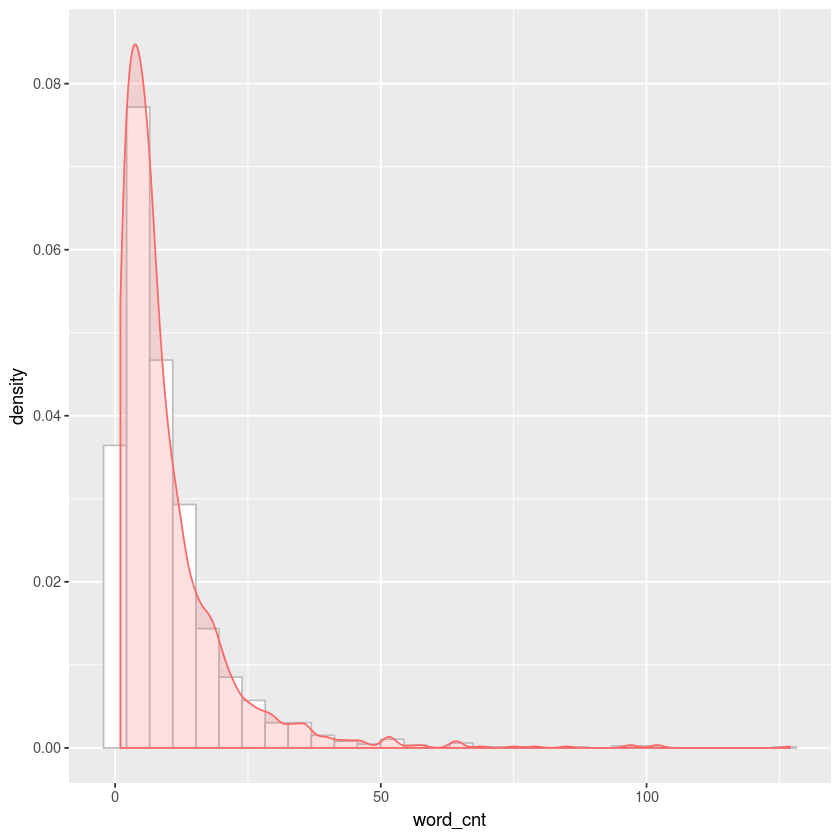

In [790]:
(
    a_dlg_word
    %>% group_by(id, movie, hero)
    %>% summarise(word_cnt = n())
#     %>% filter(word_cnt >10)
    %>% ggplot(aes(x=word_cnt))
#     + geom_histogram(binwidth=1) 
    + geom_histogram(aes(y=..density..), fill="white", color = "gray") 
    + geom_density(alpha=0.2, fill = "#FF6666", color="#FF6666" )
    
)

Joining, by = "hero"
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


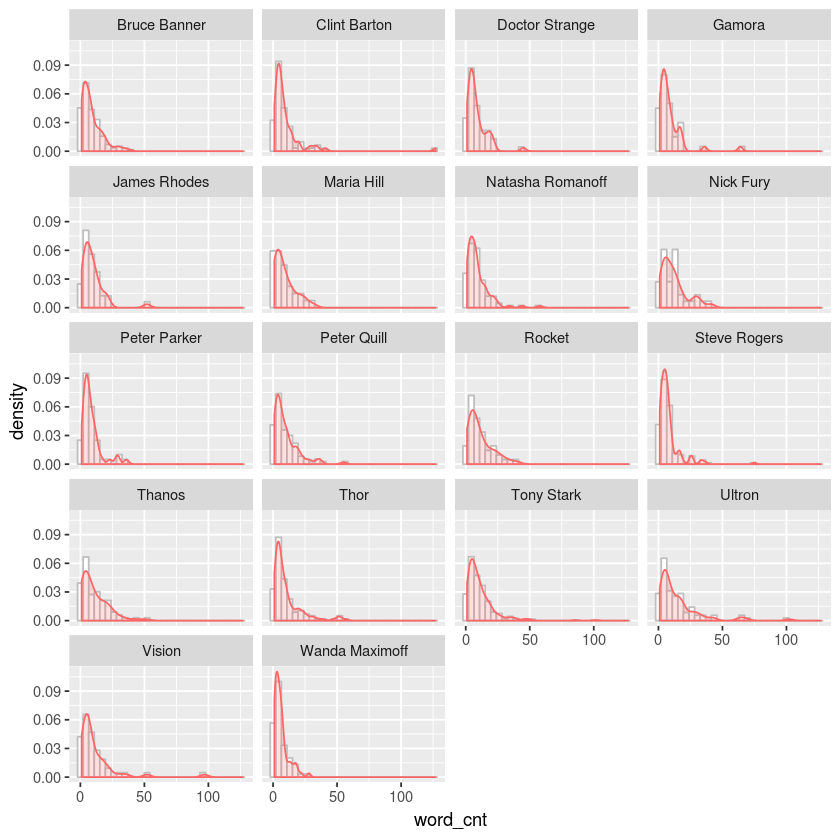

In [791]:
(
    a_dlg_word
    %>% group_by(id, movie, hero)
    %>% summarise(word_cnt = n())
    %>% arrange(hero)
    %>% inner_join(hero_list %>% filter(cnt >= 30))
    %>% ggplot(aes(x=word_cnt)) 
#     + geom_histogram(binwidth=1) 
    + geom_histogram(aes(y=..density..), fill="white", color = "gray") 
    + geom_density(alpha=0.2, fill = "#FF6666", color="#FF6666" )
    + facet_wrap(~hero, ncol=4)
    
#     %>% head(5)
)

# token analysis -  topic 02 : *time series trend*

Joining, by = "hero"


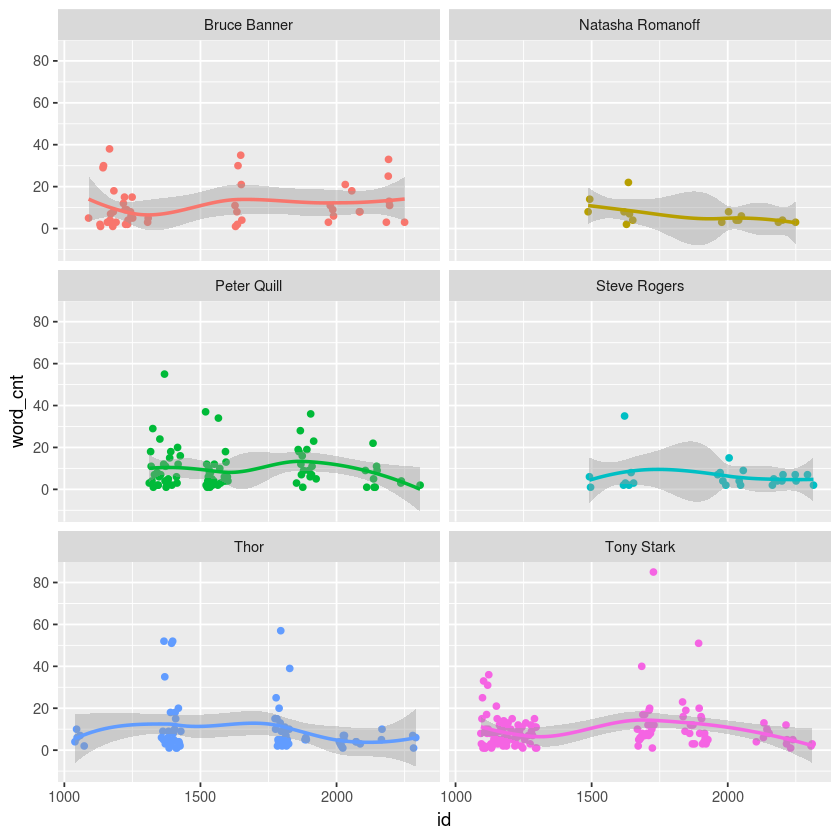

In [793]:
(
    a_dlg_word
    %>% group_by(id, movie, hero)
    %>% summarise(word_cnt = n())
    %>% filter(movie == 3)
    %>% inner_join(hero_list %>% arrange(desc(cnt)) %>% filter(cnt>=30) %>% head(6))
#     %>% filter(hero == "Steve Rogers")
    %>% ggplot(aes(x=id, y=word_cnt, color=hero))
    + geom_point()
    + geom_smooth(method='loess') 
    + facet_wrap(~hero, ncol=2)
    + theme(legend.position = "none")
    
#     %>% head(10)
)

# token analysis -  topic 03 : *word cloud*

Joining, by = "word"


NULL

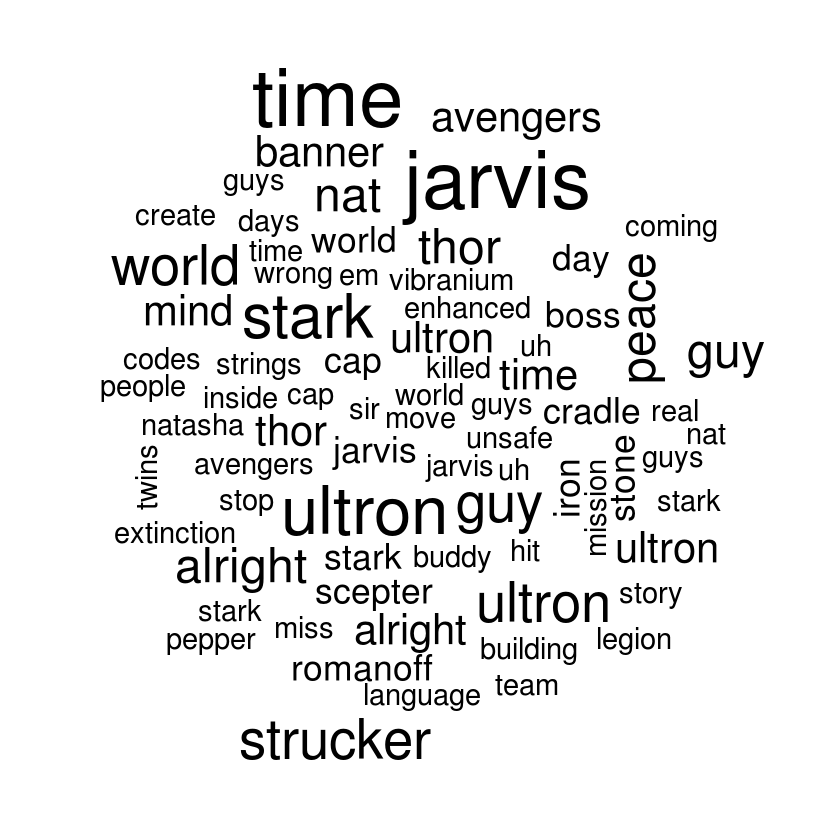

In [794]:
(
    a_dlg_word
    %>% anti_join(stop_words)
#     %>% inner_join(hero_list %>% arrange(desc(cnt)) %>% head(10))
    %>% group_by(movie, hero, word)
    %>% summarise(word_cnt=n_distinct(id))
    %>% arrange(desc(word_cnt))
    
#     %>% filter(hero == "Steve Rogers")
    %>% filter(movie == 2)
   
    %>% with(wordcloud(word, word_cnt, max.words=100))
#     %>% head(5)
)

# token analysis -  topic 04 : *dialogue network*

In [805]:
(
    a
    %>% left_join(a_dlg_word %>% group_by(id) %>% summarise(word_cnt = n()))
    %>% mutate(hero_lead_01= lead(hero))
    %>% mutate(hero_lead_02=lead(hero_lead_01))
    %>% filter(hero == hero_lead_02)
    %>% filter(hero != '' & hero_lead_01 != '' & hero_lead_02 !='')
    %>% select(hero_source = hero, hero_target = hero_lead_01, id, movie, word_cnt, dlg)
#     %>% select(hero_source = hero, hero_target, id, movie, word_cnt,dlg)
#     %>% filter(hero_source != '' & hero_target != '')
    
) 

Joining, by = "id"


hero_source,hero_target,id,movie,word_cnt,dlg
Strucker,Fortress Soldier,16,2,6,Who gave the order to attack?
Fortress Soldier,Strucker,17,2,15,"Herr Strucker, it's the Avengers. They landed in the far woods, the perimeter guard panicked."
Strucker,Fortress Soldier,18,2,11,They have to be after the scepter. Can we hold them?
Fortress Soldier,Strucker,19,2,4,They are the Avengers!
Strucker,Fortress Soldier,20,2,6,Deploy the rest of the tanks.
Strucker,Dr. List,22,2,25,Concentrate fire on the weak ones. A hit can make them close ranks. Everything we've accomplished. But we're on the verge of our greatest breakthrough.
Dr. List,Strucker,23,2,11,Then let's show them what we've accomplished. Send out the twins.
Strucker,Dr. List,24,2,3,It's too soon.
Strucker,Soldiers,34,2,22,We will not yield. The Americans sent their circus freaks to test us. We will send them back in bags. No Surrender!
Strucker,Dr. List,36,2,26,"I am going to surrender. You will delete everything. If we give the Avengers the weapons, they may not look too far into what we've been..."


In [809]:
(
    a_g
    %>% select(hero_source, hero_target, word_cnt)
#     %>% select(hero_source, hero_target)
    %>% as_tbl_graph(directed=FALSE)
    %>% activate(nodes)
    %>% mutate(neighbors = centrality_degree())
    %>% arrange(desc(neighbors))
    %>% as.tibble()
    %>% head(10)
)


name,neighbors
Tony Stark,287
Bruce Banner,126
Steve Rogers,122
Thor,101
Ultron,86
Natasha Romanoff,85
Wanda Maximoff,71
Thanos,70
Peter Quill,69
Clint Barton,55


* graph visualization

In [810]:
create_layout(
    a_g %>% 
    select(hero_source, hero_target, word_cnt) %>% 
    as_tbl_graph(directed=TRUE), layout="fr") -> layout


In [811]:
layout %>% head(3)

x,y,name,ggraph.orig_index,circular,ggraph.index
-3.994384,-0.6128486,Strucker,1,FALSE,1
-5.086589,-1.0079374,Fortress Soldier,2,FALSE,2
-5.076929,-0.2786672,Dr. List,3,FALSE,3


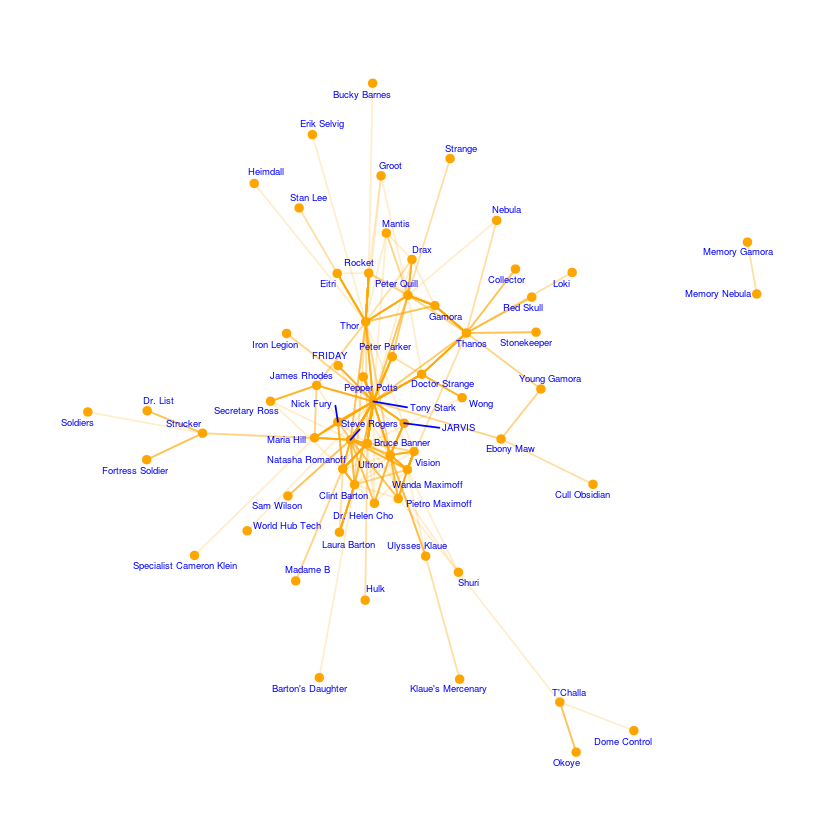

In [812]:
(
    ggraph(layout)
#     + geom_edge_density(aes(fill=word_cnt))
#     + geom_edge_link(aes(width=word_cnt), alpha = 0.2)
    + geom_edge_link(color="orange", alpha = 0.2)
#     + geom_edge_link(alpha = 0.2, width=2)
    + geom_node_point(color= 'orange', size=2)
    + geom_node_text(aes(label=name), color = "blue", size=2, repel=TRUE)
#     + scale_color_brewer(palette = "Set1")
    + theme_graph()
)

# sentiment analysis

* tidytext에서 제공하는 sentiment dictionary를 사용한 분석

* 먼저 제공해주는 sentiments 사전을 살펴보겠습니다. 

In [813]:
(
    sentiments
    %>% distinct(lexicon)
#     %>% filter(lexicon == 'nrc') %>% distinct(sentiment)
#     %>% filter(lexicon == 'AFINN') %>% distinct(score) %>% arrange(score)
#     %>% filter(lexicon=="bing") %>% distinct(sentiment) 
#     %>% filter(lexicon == "loughran") %>% distinct(sentiment)
)


lexicon
nrc
bing
AFINN
loughran


* sentiment tag를 부여하고 싶은 word를 join의 비교 대상으로 지정
* lexicon에 따라 sentiment 혹은  score를 mutate 하는 방식으로 분석

Joining, by = "word"
Joining, by = c("word", "lexicon")
Joining, by = "hero"


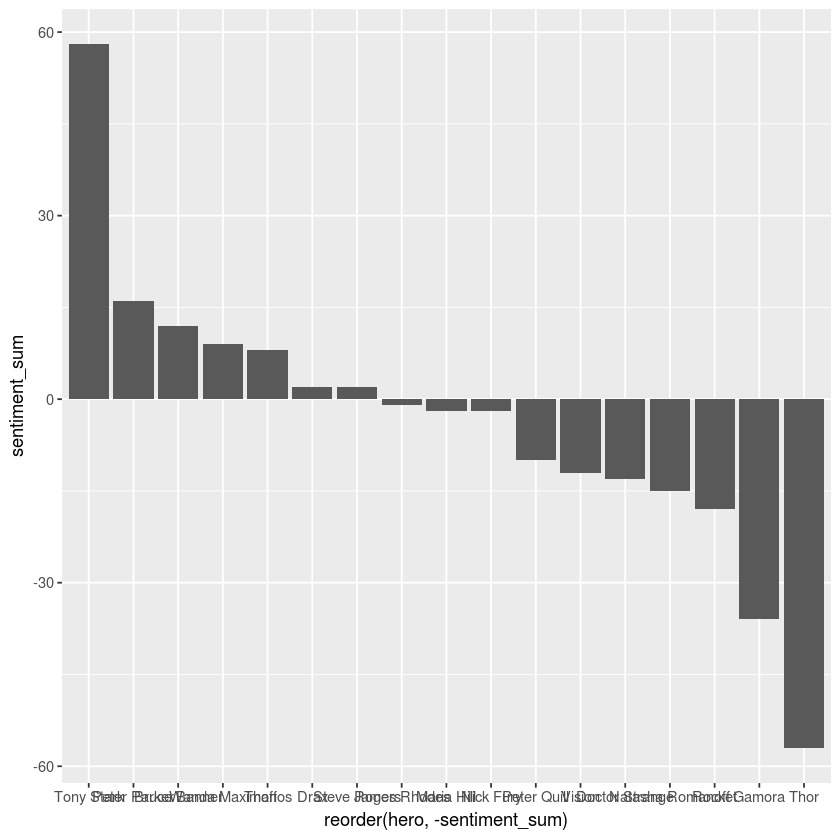

In [814]:
(
    a_dlg_word
    %>% inner_join(sentiments)
    %>% anti_join(stop_words)
    %>% inner_join(hero_list %>% arrange(desc(cnt)) %>% head(20))
    %>% filter(lexicon == "AFINN")
    %>% group_by(movie, hero)
    %>% summarise(sentiment_sum = sum(score))
    %>% arrange(desc(sentiment_sum))
    
    %>% filter(movie == 3)
    
    %>% ggplot()
    + geom_bar(aes(x=reorder(hero, -sentiment_sum), y=sentiment_sum), stat="identity")
#     %>% head(10)
)

Joining, by = "word"
Joining, by = c("word", "lexicon")
Joining, by = "hero"
Selecting by sentiment_word_sum


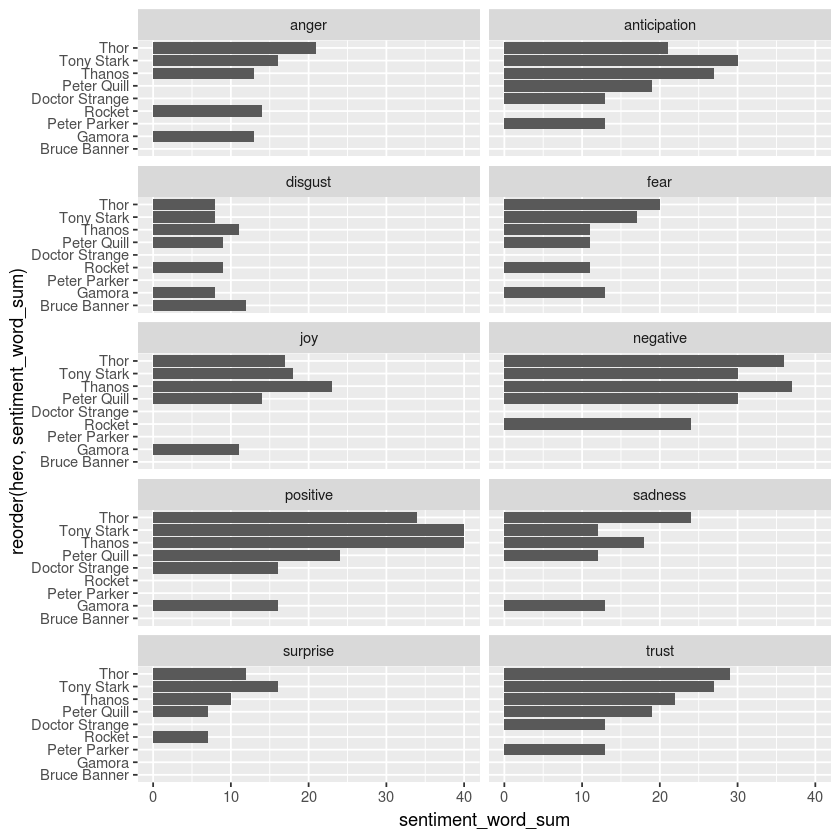

In [815]:
(
    a_dlg_word
    %>% inner_join(sentiments)
    %>% anti_join(stop_words)
    %>% inner_join(hero_list %>% arrange(desc(cnt)) %>% head(20))
    
    %>% filter(lexicon == "nrc")
    
    %>% group_by(movie, hero,sentiment, word)
    %>% summarise(id_cnt = n_distinct(id))
    
    %>% group_by(movie, sentiment, hero)
    %>% summarise(sentiment_word_sum = sum(id_cnt))
    
#     %>% filter(sentiment == "trust")
    %>% arrange(desc(sentiment_word_sum))
    %>% top_n(5)
    %>% filter(movie == 3)
    
    %>% ggplot()
    + geom_bar(aes(x=reorder(hero, sentiment_word_sum), y=sentiment_word_sum), stat="identity")
    + coord_flip()
    + facet_wrap(~ sentiment, ncol=2)
# #     %>% head(10)
)

In [816]:
(
    a_dlg_word
    %>% inner_join(sentiments)
    %>% anti_join(stop_words)
    %>% inner_join(hero_list %>% arrange(desc(cnt)) %>% head(20))
    
    %>% filter(lexicon == "nrc")
    
    %>% group_by(movie, hero,sentiment, word)
    %>% summarise(id_cnt = n_distinct(id))
    
    %>% group_by(movie, sentiment, hero)
    %>% summarise(sentiment_word_sum = sum(id_cnt))
    
    %>% filter(sentiment == "trust")
    %>% arrange(desc(sentiment_word_sum))
    %>% top_n(20)
    %>% filter(movie == 3)
    
    %>% ggplot()
    + geom_bar(aes(x=reorder(hero, sentiment_word_sum), y=sentiment_word_sum), fill="orange", color="orange", stat="identity")
    + coord_flip()
#     + facet_wrap(~ sentiment, ncol=2)
# #     %>% head(10)
) -> a_g_s_3_trust

Joining, by = "word"
Joining, by = c("word", "lexicon")
Joining, by = "hero"
Selecting by sentiment_word_sum


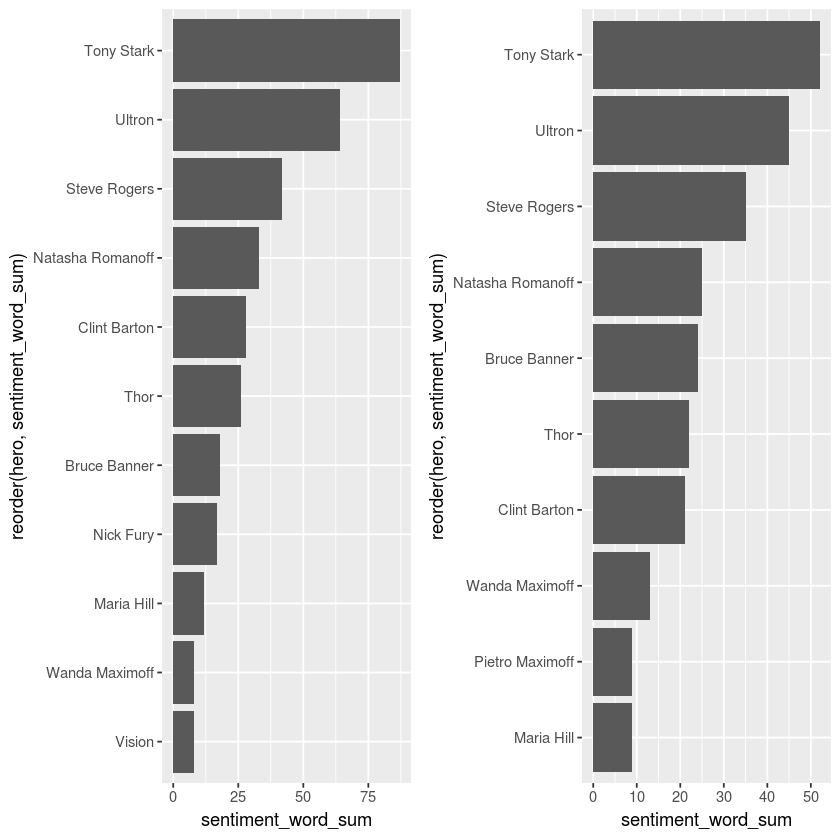

In [716]:
grid.arrange(a_g_s_2_positive, a_g_s_2_negative, ncol=2)

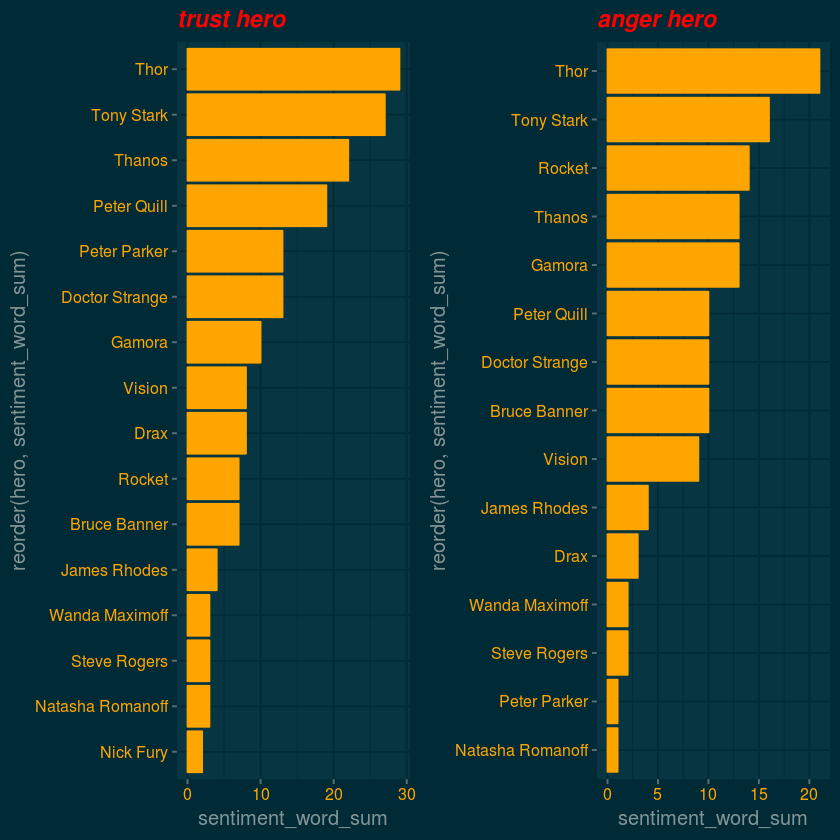

In [819]:
grid.arrange(a_g_s_3_trust, a_g_s_3_anger, ncol=2)

* 차트 모양을 좀 꾸며 보겠습니다. 

In [818]:
a_g_s_3_trust <- a_g_s_3_trust +
theme_solarized_2(light = FALSE) +
theme(
    axis.text.x = element_text(colour = "orange"), 
    axis.text.y = element_text(colour = "orange"),
    plot.title = element_text(color="red", size=14, face="bold.italic"))+
labs(title="trust hero")+
scale_colour_solarized("blue")